In [1]:
import torch
import numpy as np
import os
import random
import math
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
# from torch_geometric.data import InMemoryDataset, download_url, extract_zip
# from torch_geometric.io import read_off
from torchvision.datasets.utils import download_and_extract_archive

import torch.nn as nn
import numpy as np
import torch.nn.functional as F

import plotly.graph_objects as go
import plotly.express as px

In [2]:
# download the Modelnet10 dataset

url = 'http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip'
root = './Data'
download_and_extract_archive(url, root)

Using downloaded and verified file: ./Data\ModelNet10.zip
Extracting ./Data\ModelNet10.zip to ./Data


In [3]:
path = Path("C:\\Users\\asvp0\\Desktop\\Happiness\\Analysis-of-Point-Net-Architecture-\\data\\ModelNet10")
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

In [4]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

In [6]:
with open(path/"monitor/train/monitor_0001.off", 'r') as f:
    print(type(f))
    verts, faces = read_off(f)

<class '_io.TextIOWrapper'>


In [7]:
i,j,k = np.array(faces).T
x,y,z = np.array(verts).T

In [8]:
def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
                    layout=go.Layout(
                        updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    y=1,
                                    x=0.8,
                                    xanchor='left',
                                    yanchor='bottom',
                                    pad=dict(t=45, r=10),
                                    buttons=[dict(label='Play',
                                                    method='animate',
                                                    args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                    transition=dict(duration=0),
                                                                    fromcurrent=True,
                                                                    mode='immediate'
                                                                    )]
                                                    )
                                            ]
                                    )
                                ]
                    ),
                    frames=frames
            )

    return fig

In [ ]:
visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='lightpink', opacity=0.50, i=i,j=j,k=k)]).show()

In [11]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points
    

In [12]:
pointcloud = PointSampler(3000)((verts, faces))

In [14]:
def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()

In [ ]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

norm_pointcloud = Normalize()(pointcloud)
pcshow(*norm_pointcloud.T)

In [ ]:
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud
    
rot_pointcloud = RandRotation_z()(norm_pointcloud)
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)

pcshow(*noisy_rot_pointcloud.T)

In [17]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)
ToTensor()(noisy_rot_pointcloud)    

tensor([[-0.1474, -0.3355, -0.5194],
        [ 0.1280,  0.2033,  0.3907],
        [ 0.2946,  0.4899, -0.0859],
        ...,
        [ 0.2023,  0.1306, -0.8085],
        [-0.0142, -0.0689, -0.4838],
        [-0.3385, -0.6791, -0.3350]], dtype=torch.float64)

In [18]:
def default_transforms():
    return transforms.Compose([
                                PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])    

In [20]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(str(pcd_path), 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}

In [21]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

In [22]:
train_ds = PointCloudData(path, transform=train_transforms)
valid_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)

inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [23]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  3991
Valid dataset size:  908
Number of classes:  10
Sample pointcloud shape:  torch.Size([1024, 3])
Class:  bathtub


In [24]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

In [ ]:
import torch
from torch.utils.data import DataLoader,random_split

train_dataset = MNIST(root='./data/MNIST', download=True, train=True)
test_dataset = MNIST(root='./data/MNIST', download=True, train=False)
dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

dataset_3d = MNIST3D(dataset, number_of_points)
l_data = len(dataset_3d)
train_dataset, val_dataset, test_dataset = random_split(dataset_3d,
                                          [round(0.8*l_data), round(0.1*l_data), round(0.1*l_data)],
                                          generator=torch.Generator().manual_seed(1))

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [25]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
  
class TransformationNet(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(TransformationNet, self).__init__()
        self.output_dim = output_dim

        self.conv_1 = nn.Conv1d(input_dim, 64, 1)
        self.conv_2 = nn.Conv1d(64, 128, 1)
        self.conv_3 = nn.Conv1d(128, 256, 1)

        self.bn_1 = nn.BatchNorm1d(64)
        self.bn_2 = nn.BatchNorm1d(128)
        self.bn_3 = nn.BatchNorm1d(256)
        self.bn_4 = nn.BatchNorm1d(256)
        self.bn_5 = nn.BatchNorm1d(128)

        self.fc_1 = nn.Linear(256, 256)
        self.fc_2 = nn.Linear(256, 128)
        self.fc_3 = nn.Linear(128, self.output_dim*self.output_dim)

    def forward(self, x):
        num_points = x.shape[1]
        x = x.transpose(2, 1)
        x = F.relu(self.bn_1(self.conv_1(x)))
        x = F.relu(self.bn_2(self.conv_2(x)))
        x = F.relu(self.bn_3(self.conv_3(x)))

        x = nn.MaxPool1d(num_points)(x)
        x = x.view(-1, 256)

        x = F.relu(self.bn_4(self.fc_1(x)))
        x = F.relu(self.bn_5(self.fc_2(x)))
        x = self.fc_3(x)

        identity_matrix = torch.eye(self.output_dim)
        if torch.cuda.is_available():
            identity_matrix = identity_matrix.cuda()
        x = x.view(-1, self.output_dim, self.output_dim) + identity_matrix
        return x


class BasePointNet(nn.Module):

    def __init__(self, point_dimension):
        super(BasePointNet, self).__init__()
        self.input_transform = TransformationNet(input_dim=point_dimension, output_dim=point_dimension)
        self.feature_transform = TransformationNet(input_dim=64, output_dim=64)
        
        self.conv_1 = nn.Conv1d(point_dimension, 64, 1)
        self.conv_2 = nn.Conv1d(64, 64, 1)
        self.conv_3 = nn.Conv1d(64, 64, 1)
        self.conv_4 = nn.Conv1d(64, 128, 1)
        self.conv_5 = nn.Conv1d(128, 256, 1)

        self.bn_1 = nn.BatchNorm1d(64)
        self.bn_2 = nn.BatchNorm1d(64)
        self.bn_3 = nn.BatchNorm1d(64)
        self.bn_4 = nn.BatchNorm1d(128)
        self.bn_5 = nn.BatchNorm1d(256)
        

    def forward(self, x, plot=False):
        num_points = x.shape[1]
        
        input_transform = self.input_transform(x) # T-Net tensor [batch, 3, 3]
        x = torch.bmm(x, input_transform) # Batch matrix-matrix product 
        x = x.transpose(2, 1) 
        tnet_out=x.cpu().detach().numpy()
        
        x = F.relu(self.bn_1(self.conv_1(x)))
        x = F.relu(self.bn_2(self.conv_2(x)))
        x = x.transpose(2, 1)

        feature_transform = self.feature_transform(x) # T-Net tensor [batch, 64, 64]
        x = torch.bmm(x, feature_transform)
        x = x.transpose(2, 1)
        x = F.relu(self.bn_3(self.conv_3(x)))
        x = F.relu(self.bn_4(self.conv_4(x)))
        x = F.relu(self.bn_5(self.conv_5(x)))
        x, ix = nn.MaxPool1d(num_points, return_indices=True)(x)  # max-pooling
        x = x.view(-1, 256)  # global feature vector 

        return x, feature_transform, tnet_out, ix


class ClassificationPointNet(nn.Module):

    def __init__(self, num_classes, dropout=0.3, point_dimension=3):
        super(ClassificationPointNet, self).__init__()
        self.base_pointnet = BasePointNet(point_dimension=point_dimension)

        self.fc_1 = nn.Linear(256, 128)
        self.fc_2 = nn.Linear(128, 64)
        self.fc_3 = nn.Linear(64, num_classes)

        self.bn_1 = nn.BatchNorm1d(128)
        self.bn_2 = nn.BatchNorm1d(64)

        self.dropout_1 = nn.Dropout(dropout)

    def forward(self, x):
        x, feature_transform, tnet_out, ix_maxpool = self.base_pointnet(x)

        x = F.relu(self.bn_1(self.fc_1(x)))
        x = F.relu(self.bn_2(self.fc_2(x)))
        x = self.dropout_1(x)

        return F.log_softmax(self.fc_3(x), dim=1), feature_transform, tnet_out, ix_maxpool


In [26]:
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm
import os

model = ClassificationPointNet(num_classes=dataset_3d.NUM_CLASSIFICATION_CLASSES,
                                   point_dimension=dataset_3d.POINT_DIMENSION)
if torch.cuda.is_available():
    model.cuda()
    device = 'cuda'
else:
    device = 'cpu'

optimizer = optim.Adam(model.parameters(), lr=learning_rate)


NameError: name 'dataset_3d' is not defined

In [12]:
!pip install prettytable
from prettytable import PrettyTable

table = PrettyTable(["Modules", "Parameters"])
total_params = 0
for name, parameter in model.named_parameters():
    if not parameter.requires_grad: continue
    params = parameter.numel()
    table.add_row([name, params])
    total_params+=params
print(table)
print(f"Total Trainable Params: {total_params}")


+-----------------------------------------------+------------+
|                    Modules                    | Parameters |
+-----------------------------------------------+------------+
|  base_pointnet.input_transform.conv_1.weight  |    192     |
|   base_pointnet.input_transform.conv_1.bias   |     64     |
|  base_pointnet.input_transform.conv_2.weight  |    8192    |
|   base_pointnet.input_transform.conv_2.bias   |    128     |
|  base_pointnet.input_transform.conv_3.weight  |   32768    |
|   base_pointnet.input_transform.conv_3.bias   |    256     |
|   base_pointnet.input_transform.bn_1.weight   |     64     |
|    base_pointnet.input_transform.bn_1.bias    |     64     |
|   base_pointnet.input_transform.bn_2.weight   |    128     |
|    base_pointnet.input_transform.bn_2.bias    |    128     |
|   base_pointnet.input_transform.bn_3.weight   |    256     |
|    base_pointnet.input_transform.bn_3.bias    |    256     |
|   base_pointnet.input_transform.bn_4.weight   |    25

In [13]:
# Load checkpoint
# model_checkpoint= 'checkpoints/3Dmnist_classification_checkpoint_200e100.pth'

# if model_checkpoint:
#     state = torch.load(model_checkpoint)
#     model.load_state_dict(state['model'])    
#     optimizer.load_state_dict(state['optimizer'])

In [14]:
# training model
epochs=15
train_loss = []
test_loss = []
train_acc = []
test_acc = []
best_loss= np.inf

for epoch in tqdm(range(epochs)):
    epoch_train_loss = []
    epoch_train_acc = []

    # training loop
    for data in train_dataloader:
        points, targets = data  # [batch, num_points, 3] [batch]

        if torch.cuda.is_available():
            points, targets = points.cuda(), targets.cuda()
        if points.shape[0] <= 1:
            continue
        optimizer.zero_grad()
        model = model.train()
        preds, feature_transform, tnet_out, ix_maxpool = model(points)

        identity = torch.eye(feature_transform.shape[-1])
        if torch.cuda.is_available():
            identity = identity.cuda()
        regularization_loss = torch.norm(
            identity - torch.bmm(feature_transform, feature_transform.transpose(2, 1)))
        # Loss
        loss = F.nll_loss(preds, targets) + 0.001 * regularization_loss
        epoch_train_loss.append(loss.cpu().item())
        loss.backward()
        optimizer.step()
        preds = preds.data.max(1)[1]
        corrects = preds.eq(targets.data).cpu().sum()

        accuracy = corrects.item() / float(batch_size)
        epoch_train_acc.append(accuracy)

    epoch_test_loss = []
    epoch_test_acc = []

    # validation loop
    for batch_number, data in enumerate(test_dataloader):
        points, targets = data
        if torch.cuda.is_available():
            points, targets = points.cuda(), targets.cuda()
        model = model.eval()
        preds, feature_transform, tnet_out, ix = model(points)
        loss = F.nll_loss(preds, targets)
        epoch_test_loss.append(loss.cpu().item())
        preds = preds.data.max(1)[1]
        corrects = preds.eq(targets.data).cpu().sum()
        accuracy = corrects.item() / float(batch_size)
        epoch_test_acc.append(accuracy)

    print('Epoch %s: train loss: %s, val loss: %f, train accuracy: %s,  val accuracy: %f'
              % (epoch,
                round(np.mean(epoch_train_loss), 4),
                round(np.mean(epoch_test_loss), 4),
                round(np.mean(epoch_train_acc), 4),
                round(np.mean(epoch_test_acc), 4)))

    if np.mean(test_loss) < best_loss:
        state = {
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict()
        }
        torch.save(state, os.path.join('checkpoints', '3Dmnist_checkpoint_%s.pth' % (number_of_points)))
        best_loss=np.mean(test_loss)

    train_loss.append(np.mean(epoch_train_loss))
    test_loss.append(np.mean(epoch_test_loss))
    train_acc.append(np.mean(epoch_train_acc))
    test_acc.append(np.mean(epoch_test_acc))


  0%|          | 0/15 [00:00<?, ?it/s]

c:\Users\asvp0\Anaconda3\envs\dl21\lib\site-packages\torch\nn\functional.py:651: UserWarning:

Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool1d in a future release.



Epoch 0: train loss: 0.6492, val loss: 0.443500, train accuracy: 0.8408,  val accuracy: 0.853400


c:\Users\asvp0\Anaconda3\envs\dl21\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning:

Mean of empty slice.

c:\Users\asvp0\Anaconda3\envs\dl21\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars



Epoch 1: train loss: 0.229, val loss: 0.307600, train accuracy: 0.94,  val accuracy: 0.907100
Epoch 2: train loss: 0.1703, val loss: 0.198100, train accuracy: 0.9534,  val accuracy: 0.934700
Epoch 3: train loss: 0.1429, val loss: 0.198200, train accuracy: 0.9592,  val accuracy: 0.933200
Epoch 4: train loss: 0.1296, val loss: 0.209100, train accuracy: 0.962,  val accuracy: 0.935900
Epoch 5: train loss: 0.1126, val loss: 0.129100, train accuracy: 0.9667,  val accuracy: 0.954500
Epoch 6: train loss: 0.1015, val loss: 0.137100, train accuracy: 0.9696,  val accuracy: 0.953400
Epoch 7: train loss: 0.0951, val loss: 0.107500, train accuracy: 0.9724,  val accuracy: 0.963500
Epoch 8: train loss: 0.0892, val loss: 0.121800, train accuracy: 0.9728,  val accuracy: 0.959400
Epoch 9: train loss: 0.0845, val loss: 0.435600, train accuracy: 0.9742,  val accuracy: 0.890200
Epoch 10: train loss: 0.082, val loss: 0.146500, train accuracy: 0.9741,  val accuracy: 0.953800
Epoch 11: train loss: 0.0721, val 

In [16]:
# plot loss and accuracy

def plot_losses(train_loss, test_loss, save_to_file=None):
    fig = plt.figure()
    epochs = len(train_loss)
    plt.plot(range(epochs), train_loss, 'b', label='Training loss')
    plt.plot(range(epochs), test_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    if save_to_file:
        fig.savefig(save_to_file,dpi=200)


def plot_accuracies(train_acc, test_acc, save_to_file=None):
    fig = plt.figure()
    epochs = len(train_acc)
    plt.plot(range(epochs), train_acc, 'b', label='Training accuracy')
    plt.plot(range(epochs), test_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    if save_to_file:
        fig.savefig(save_to_file)

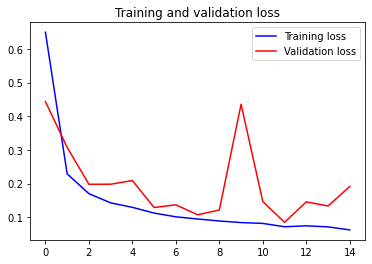

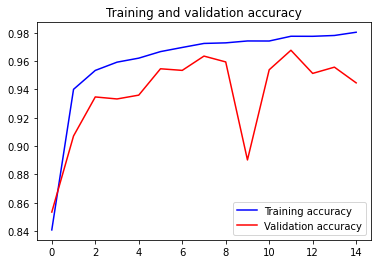

In [17]:
output_folder='figures'

plot_losses(train_loss, test_loss, save_to_file=os.path.join(output_folder, 'loss_plot_200p.png'))
plot_accuracies(train_acc, test_acc, save_to_file=os.path.join(output_folder, 'accuracy_plot_200p.png'))

#Test model

In [21]:

def infer(dataset,
          model,
          point_cloud_file,
          shuffle_points=False,
          plot_tNet_out=True,
          return_indices_maxpool=False):
    
    num_classes = dataset.NUM_CLASSIFICATION_CLASSES
    points, label = point_cloud_file
    
    if torch.cuda.is_available():
        points = points.cuda()
        model.cuda()

    points = points.unsqueeze(dim=0)
    model = model.eval()
    preds, feature_transform, tnet_out, ix = model(points)
    preds = preds.data.max(1)[1]

    points = points.cpu().numpy().squeeze()
    preds = preds.cpu().numpy()

    if return_indices_maxpool:
        return preds, tnet_out, ix

    return preds, tnet_out

Compute accuracy on test set

In [23]:
from tqdm.notebook import tqdm
corrects=0

# load checkpoint
# model_checkpoint = '/content/checkpoints/3Dmnist_checkpoint_200.pth'
# if model_checkpoint:
#     state = torch.load(model_checkpoint, map_location=torch.device(device))
#     model.load_state_dict(state['model'])  

for i in tqdm(range(len(test_dataset))):
    target=test_dataset[i][1]
    pred, tnet_out = infer(dataset_3d, model, test_dataset[i], shuffle_points=False, plot_tNet_out=False)    
    if target == pred:
        corrects+=1

print(f'Accuracy = {corrects/len(test_dataset)}')

  0%|          | 0/7000 [00:00<?, ?it/s]

c:\Users\asvp0\Anaconda3\envs\dl21\lib\site-packages\torch\nn\functional.py:651: UserWarning:

Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool1d in a future release.



Accuracy = 0.951


Plot input and output of T-Net

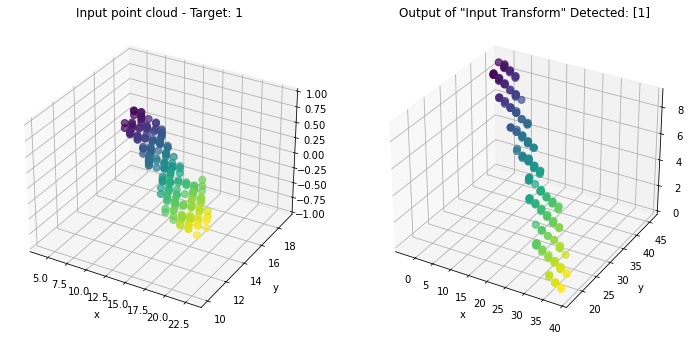

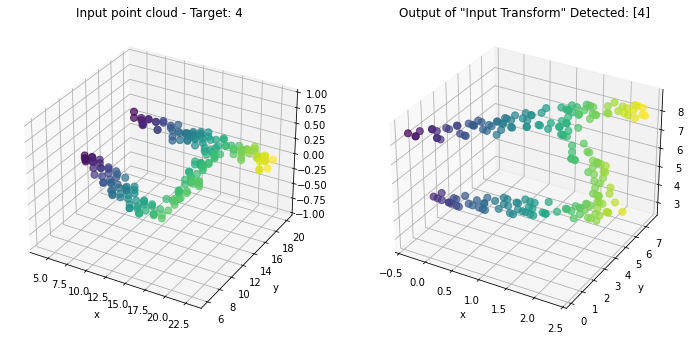

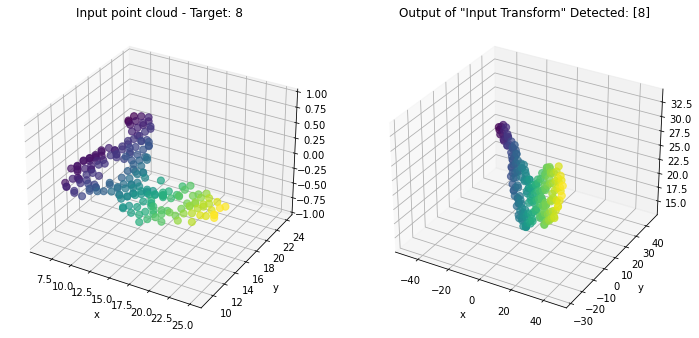

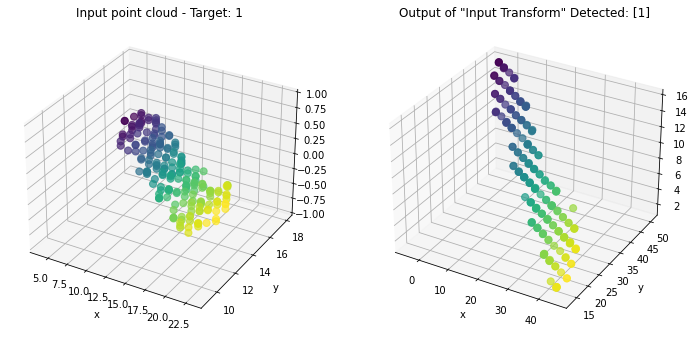

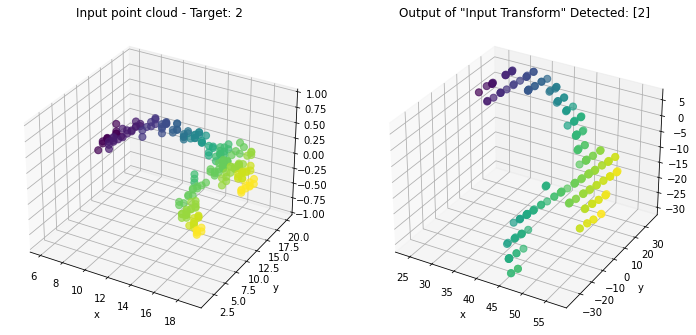

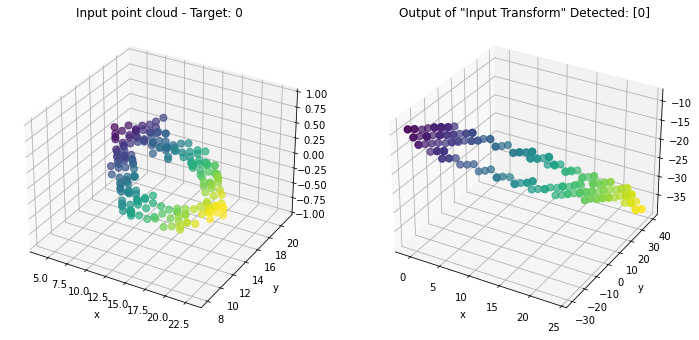

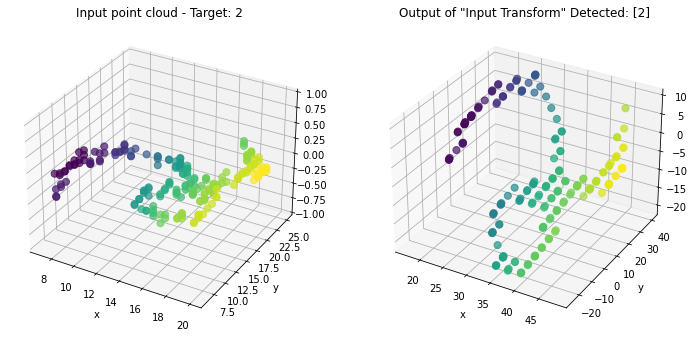

In [24]:
# Plot 7 samples
for SAMPLE in range(7):

    fig = plt.figure(figsize=[12,6])
    ax = fig.add_subplot(1, 2, 1, projection='3d')

    # plot input sample
    pc = test_dataset[SAMPLE][0].numpy()
    label = test_dataset[SAMPLE][1]
    sc = ax.scatter(pc[:,0], pc[:,1], pc[:,2], c=pc[:,0] ,s=50, marker='o', cmap="viridis", alpha=0.7)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlim3d(-1, 1)
    ax.title.set_text(f'Input point cloud - Target: {label}')

    # plot transformation
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    preds, tnet_out = infer(dataset_3d, model,test_dataset[SAMPLE])
    points=tnet_out
    sc = ax.scatter(points[0,0,:], points[0,1,:], points[0,2,:], c=points[0,0,:] ,s=50, marker='o', cmap="viridis", alpha=0.7)
    ax.title.set_text(f'Output of "Input Transform" Detected: {preds}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.savefig(f'figures/Tnet-out-{label}.png',dpi=100)

    #print('Detected class: %s' % preds)


One of the properties of PointNet is that it is invariant to permutations of points. Let's test it! We are going to shuffle points and visualize the transformation.

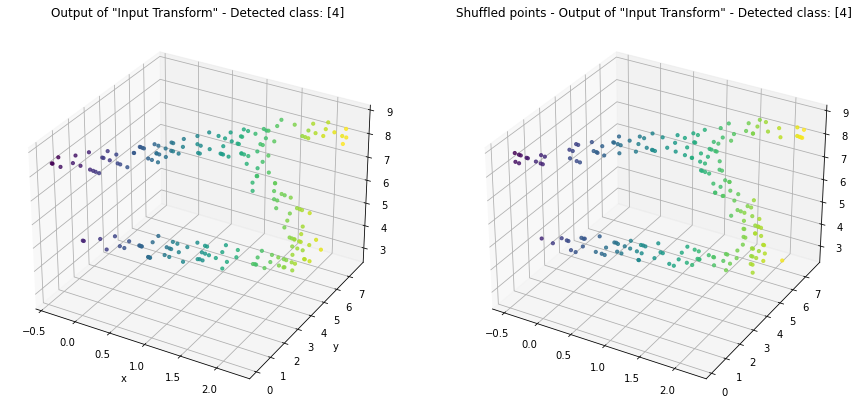

In [26]:
# select sample from test dataset
SAMPLE=1 

fig = plt.figure(figsize=[15,8])
ax = fig.add_subplot(1, 2, 1, projection='3d')
label = test_dataset[SAMPLE][1]

# plot transformation
preds, tnet_out = infer(dataset_3d, model, test_dataset[SAMPLE])
points=tnet_out
sc = ax.scatter(points[0,0,:], points[0,1,:], points[0,2,:], c=points[0,0,:] ,s=10, marker='o', cmap="viridis", alpha=0.8)
ax.title.set_text('Output of "Input Transform" - Detected class: %s' % preds)
ax.set_xlabel('x')
ax.set_ylabel('y')

# plot transformation with shuffled points
ax = fig.add_subplot(1, 2, 2, projection='3d')
preds, tnet_out = infer(dataset_3d, model, test_dataset[SAMPLE], shuffle_points=True)
points=tnet_out
sc = ax.scatter(points[0,0,:], points[0,1,:], points[0,2,:], c=points[0,0,:] ,s=10, marker='o', cmap="viridis", alpha=0.8)
ax.title.set_text('Shuffled points - Output of "Input Transform" - Detected class: %s' % preds)
plt.savefig(f'figures/Tnet-out-shuffle-{label}.png',dpi=100)

plt.show()


In [30]:
from tqdm.notebook import tqdm
results=[]
results_shuffle=[]
tnet_out_list =[]
tnet_out_shuffle_list =[]
list_ix_o = []
list_ix_shuffle = []

for i in tqdm(range(len(test_dataset))):
    preds, tnet_out, ix_o = infer(dataset_3d, model, test_dataset[i], shuffle_points=False, 
                                        plot_tNet_out=False, return_indices_maxpool=True)    
    results.append(int(preds))
    tnet_out_list.append(tnet_out) # store output of T-Net
    list_ix_o.append(ix_o.cpu()) # store max-poolng indices
    
    preds, tnet_out_shuf, ix_shuffle = infer(dataset_3d, model, test_dataset[i], shuffle_points=True,
                                         plot_tNet_out=False, return_indices_maxpool=True)    
    
    results_shuffle.append(int(preds))
    tnet_out_shuffle_list.append(tnet_out_shuf)
    list_ix_shuffle.append(ix_shuffle.cpu())
    
    
    
    

  0%|          | 0/7000 [00:00<?, ?it/s]

c:\Users\asvp0\Anaconda3\envs\dl21\lib\site-packages\torch\nn\functional.py:651: UserWarning:

Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool1d in a future release.



In [31]:
# Get index of different predictions
idx=0
res=[]
# With iteration
for i in results:
    if results[idx] != results_shuffle[idx]:
        res.append(idx)
    idx = idx + 1

# Result
print("The index positions with mismatched values:\n",res)

The index positions with mismatched values:
 [279, 294, 400, 1245, 2472, 3221, 3966, 4289, 5768, 6522, 6943]


Sample: 279


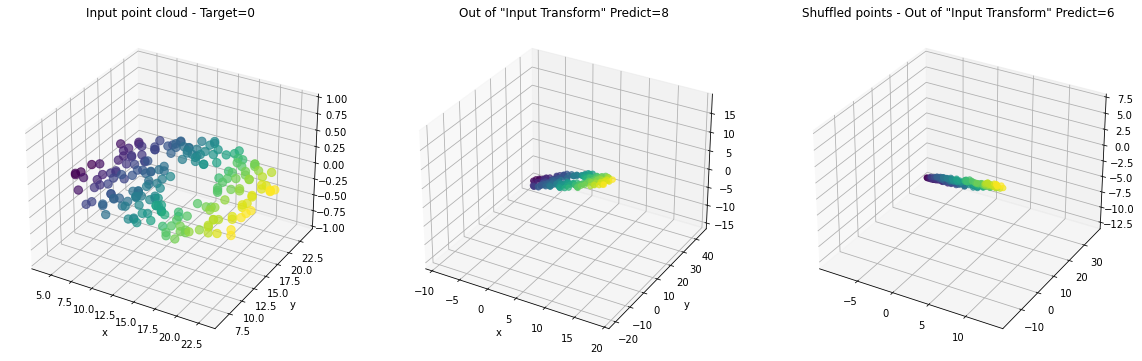

Sample: 294


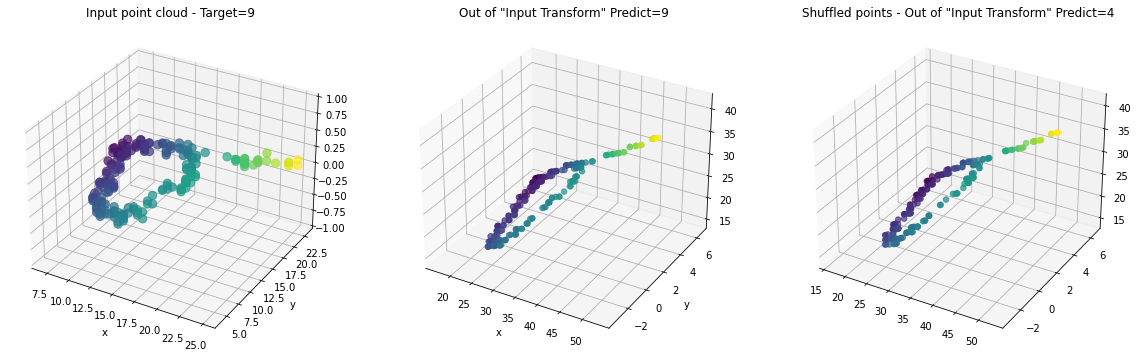

Sample: 400


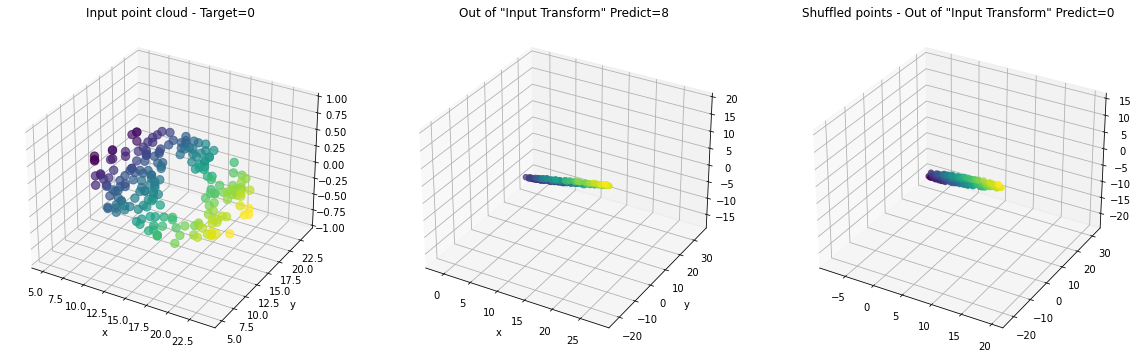

Sample: 1245


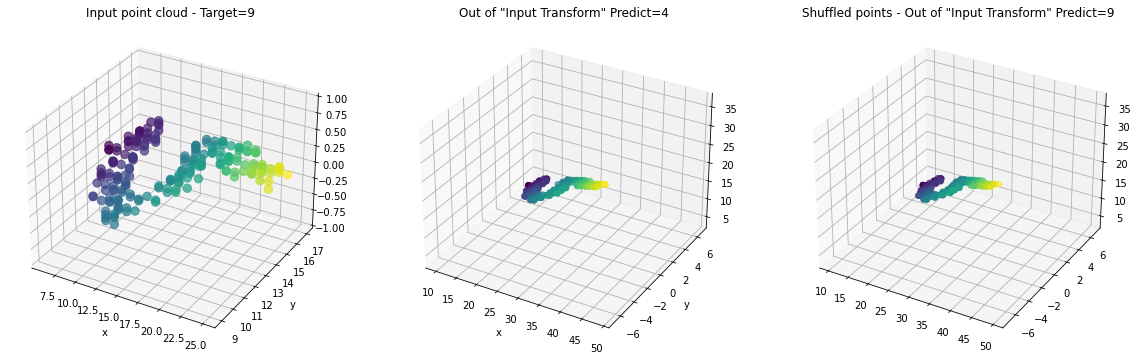

Sample: 2472


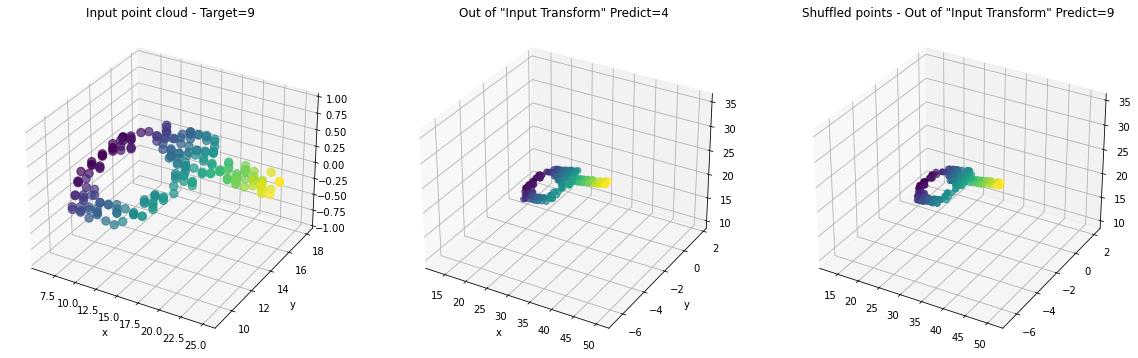

Sample: 3221


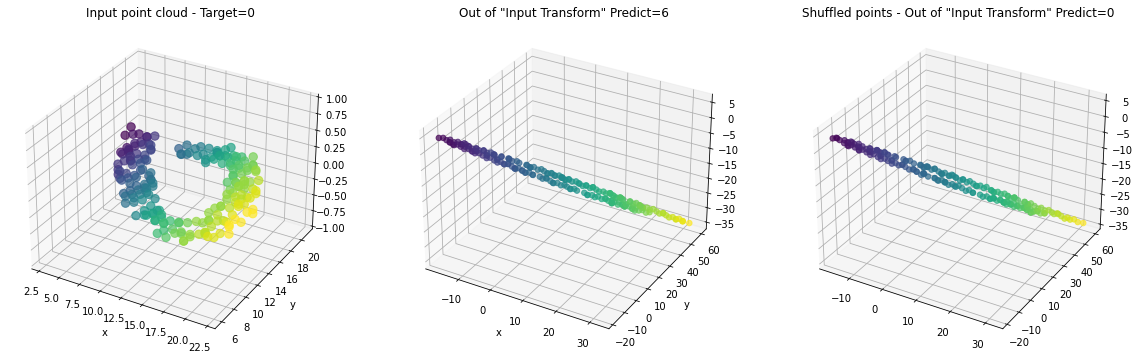

Sample: 3966


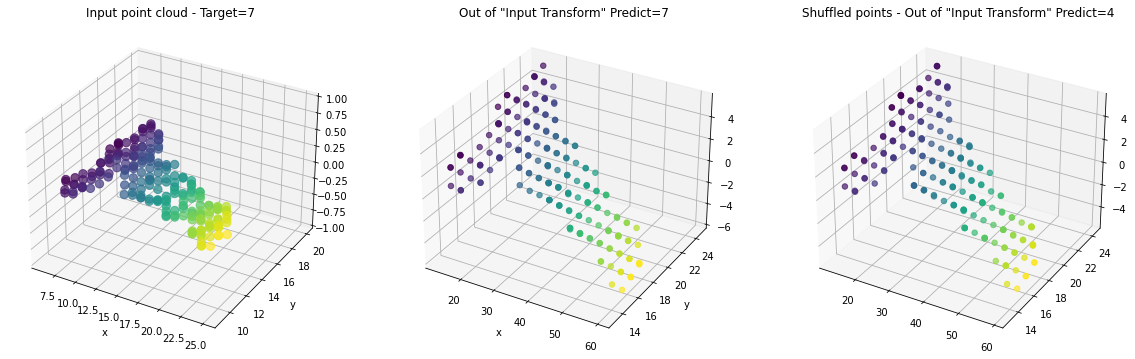

Sample: 4289


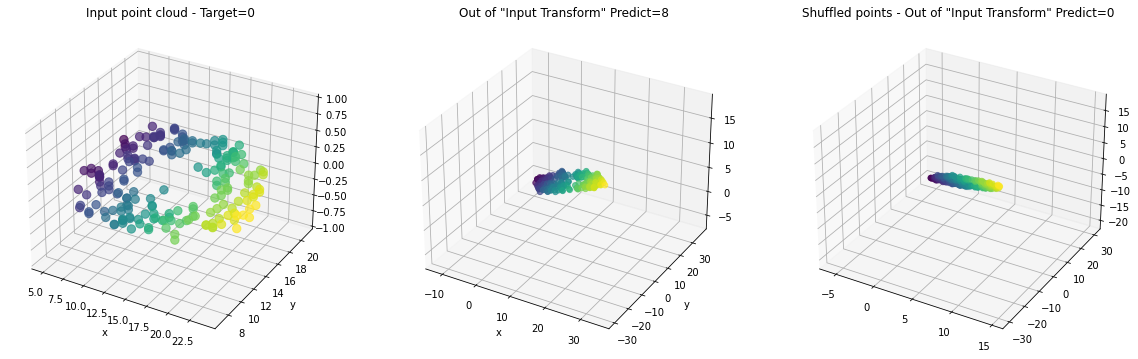

Sample: 5768


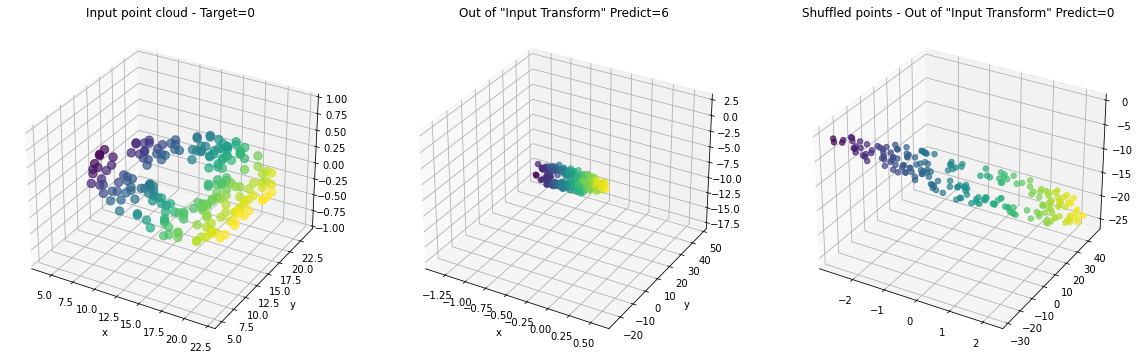

Sample: 6522


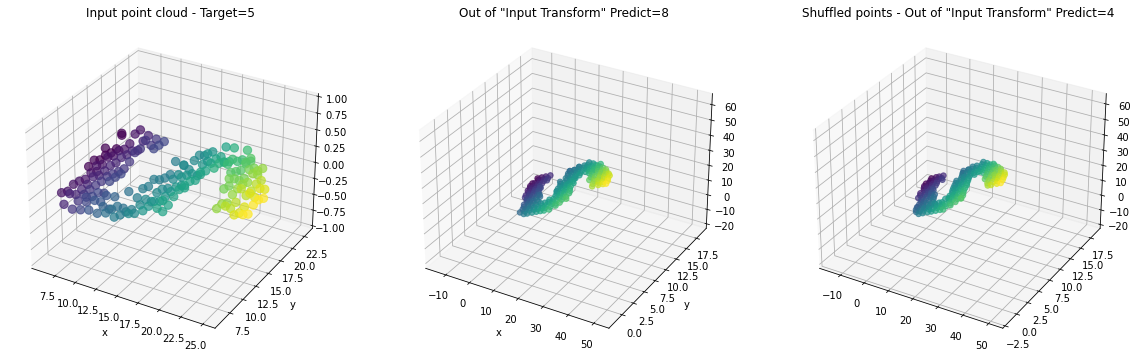

Sample: 6943


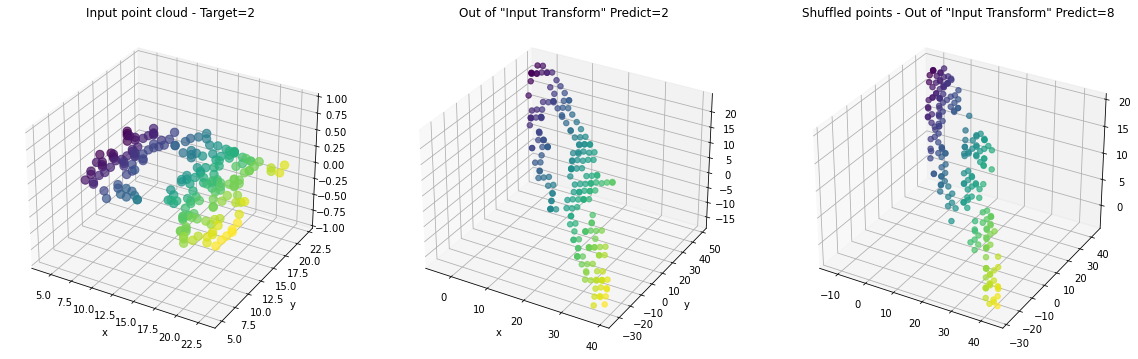

In [35]:
# select sample from test dataset
for i in range(len(res)):
    SAMPLE=res[i]

    fig = plt.figure(figsize=[20,6])
    input_points = test_dataset[SAMPLE][0]
    label = test_dataset[SAMPLE][1]
    print(f'Sample: {SAMPLE}')

    # plot input sample
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    pc = test_dataset[SAMPLE][0].numpy()
    sc = ax.scatter(pc[:,0], pc[:,1], pc[:,2], c=pc[:,0] ,s=70, marker='o', cmap="viridis", alpha=0.7)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlim3d(-1, 1)
    ax.title.set_text(f'Input point cloud - Target={label}')

    # plot transformation
    ax = fig.add_subplot(1, 3, 2, projection='3d')

    preds = results[SAMPLE]
    points = tnet_out_list[SAMPLE]

    sc = ax.scatter(points[0,0,:], points[0,1,:], points[0,2,:], c=points[0,0,:] ,s=30, marker='o', 
                    cmap="viridis", alpha=0.7)
    ax.title.set_text('Out of "Input Transform" Predict=%s' % preds)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # plot transformation with shuffled points
    ax = fig.add_subplot(1, 3, 3, projection='3d')
    preds = results_shuffle[SAMPLE]
    points = tnet_out_shuffle_list[SAMPLE]
    sc = ax.scatter(points[0,0,:], points[0,1,:], points[0,2,:], c=points[0,0,:] ,s=30, marker='o', 
                    cmap="viridis", alpha=0.7)
    ax.title.set_text('Shuffled points - Out of "Input Transform" Predict=%s' % preds)
    plt.show()
    


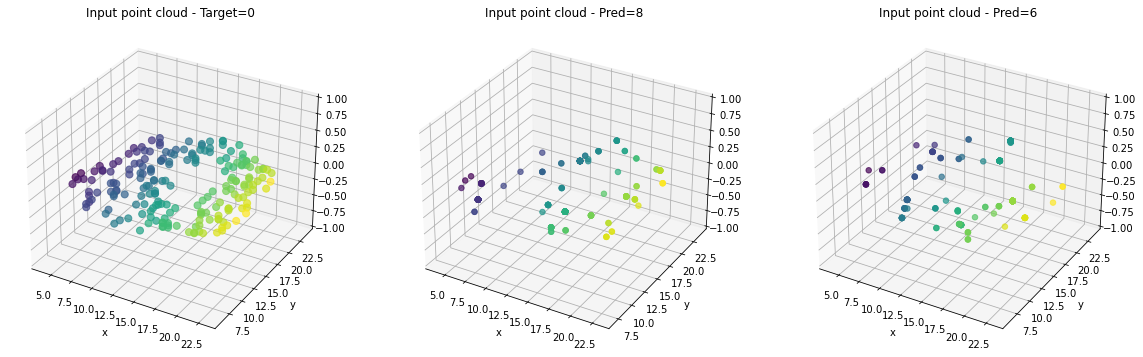

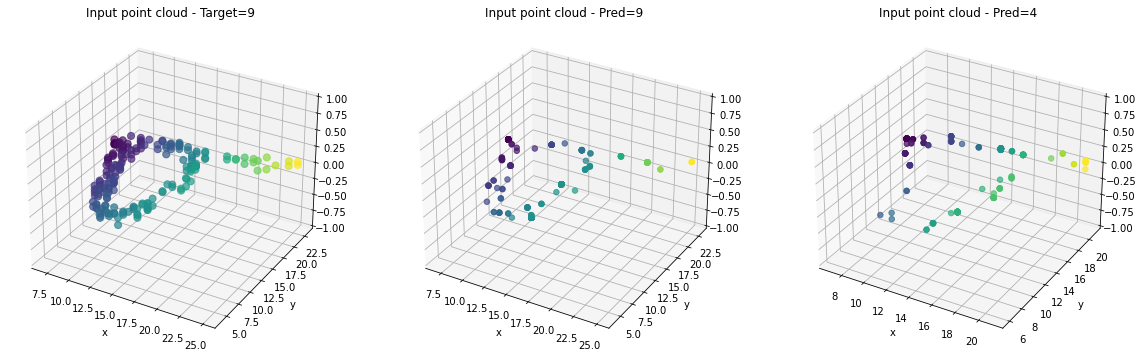

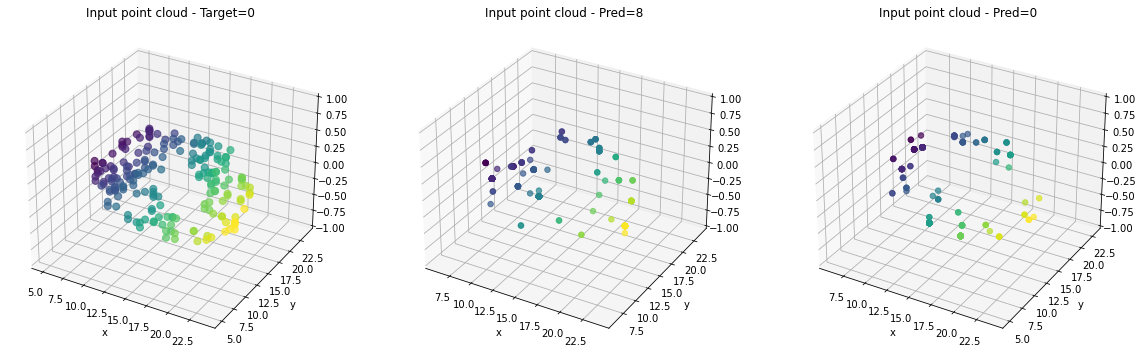

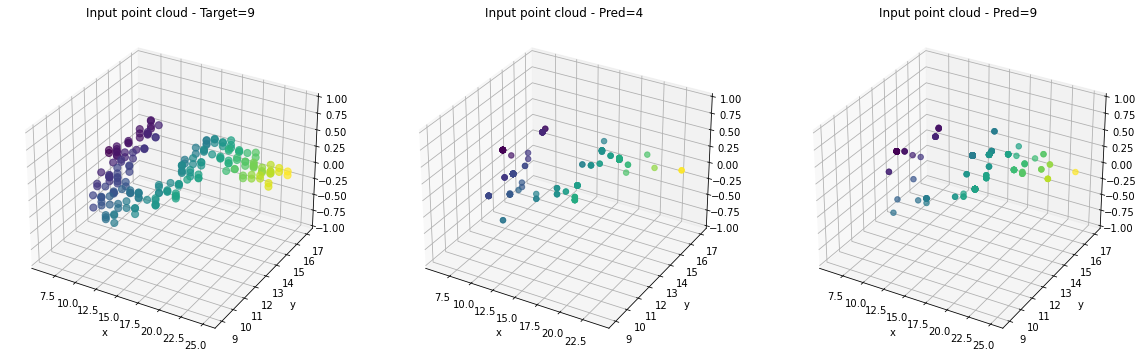

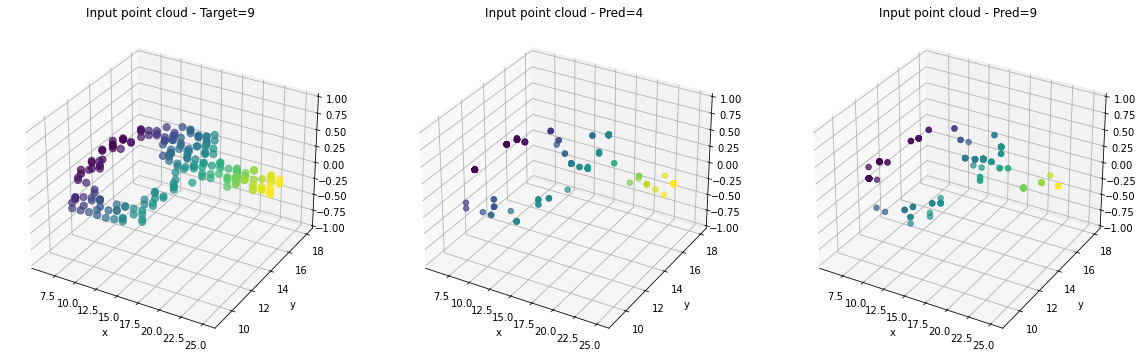

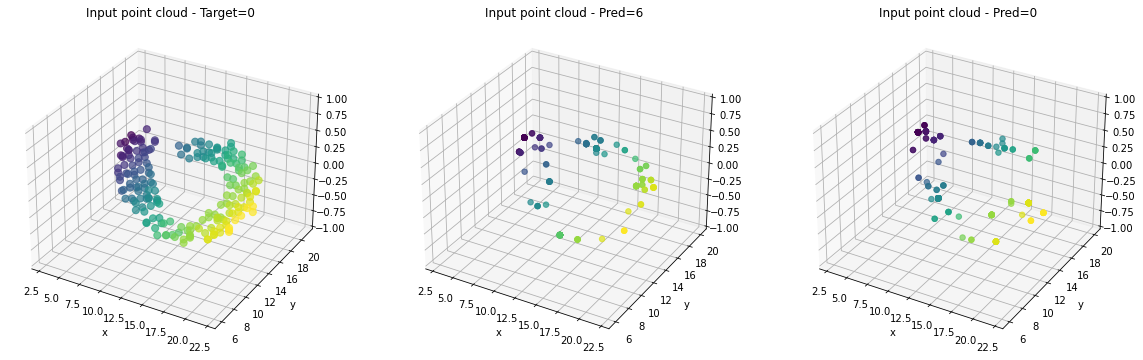

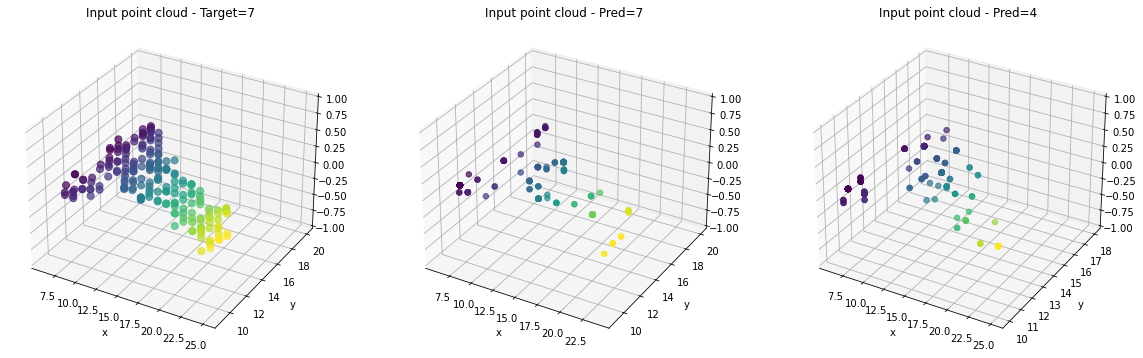

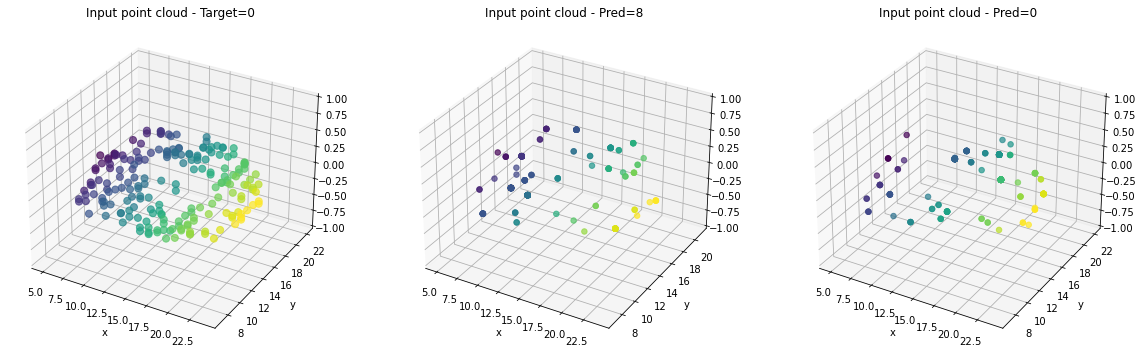

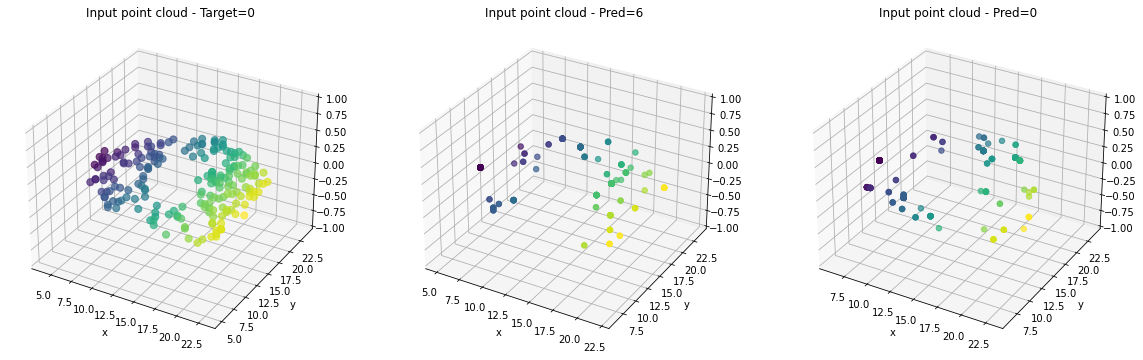

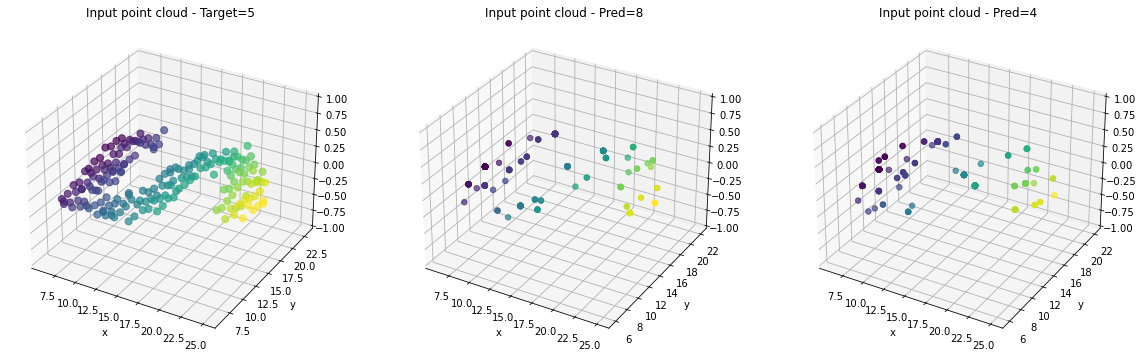

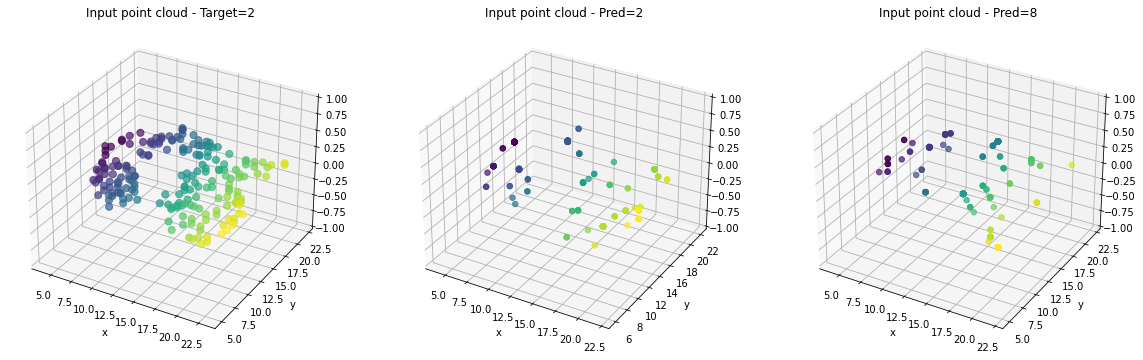

In [36]:
# select sample from test dataset
for k in range(len(res)):
    SAMPLE = res[k]

    pc = test_dataset[SAMPLE][0].numpy()
    fig = plt.figure(figsize=[20,6])
    input_points = test_dataset[SAMPLE][0]
    label = test_dataset[SAMPLE][1]

    # plot input sample
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    sc = ax.scatter(pc[:,0], pc[:,1], pc[:,2], c=pc[:,0] ,s=50, marker='o', cmap="viridis", alpha=0.7)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlim3d(-1, 1)
    ax.title.set_text(f'Input point cloud - Target={label}')

    # plot critical points
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    pc1 = pc[list(set(list_ix_o[0].reshape(256))), :]
    sc = ax.scatter(pc1[:,0], pc1[:,1], pc1[:,2], c=pc1[:,0] ,s=30, marker='o', cmap="viridis", alpha=0.7)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlim3d(-1, 1)
    preds = results[SAMPLE]
    ax.title.set_text(f'Input point cloud - Pred={preds}')
    
    ax = fig.add_subplot(1, 3, 3, projection='3d')
    pc = test_dataset[SAMPLE][0].numpy()
    pc = pc[list(set(list_ix_shuffle[0].reshape(256))), :]
    sc = ax.scatter(pc[:,0], pc[:,1], pc[:,2], c=pc[:,0] ,s=30, marker='o', cmap="viridis", alpha=0.7)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlim3d(-1, 1)
    preds = results_shuffle[SAMPLE]
    ax.title.set_text(f'Input point cloud - Pred={preds}')